In [1]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from gspread_formatting import *
from collections import Counter
import numpy as np
import time

import pandas as pd
import geopandas as gpd
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import itertools as it

plt.rc('axes', axisbelow=True)
%matplotlib inline

In [2]:
today = time.strftime("%Y-%m-%d")

weekday_mapping = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}

alldates = pd.date_range(start='2020-01-06', end='2021-12-31').tolist()
datelist = [str(i.date()) for i in alldates]
weekdays = [weekday_mapping[i.date().weekday()] for i in alldates]
weeklist = [i//7 for i in range(len(alldates))]
DATE_DF = pd.DataFrame({'date':datelist,'day':weekdays,'week':weeklist})
DATERANGE = DATE_DF['date'].tolist()

date_dict = {DATERANGE[i]:i for i in range(len(DATERANGE))}

In [3]:
# use creds to create a client to interact with the Google Drive API
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

creds = ServiceAccountCredentials.from_json_keyfile_name('../../universities/data/client_secret.json', scope)
client = gspread.authorize(creds)

mass_data = client.open("COVID-data-Massachusetts")
contact_data = mass_data.worksheet('contact_tracing')
city_data = mass_data.worksheet('town_data')

contact_df = pd.DataFrame(contact_data.get_all_records())
city_df = pd.DataFrame(city_data.get_all_records())

contact_df.loc[contact_df['raw_new_clusters']=='','raw_new_clusters'] = np.nan
contact_df.loc[contact_df['raw_new_cases']=='','raw_new_cases'] = np.nan
contact_df.loc[contact_df['raw_new_contacts']=='','raw_new_contacts'] = np.nan
contact_df.loc[contact_df['raw_total_clusters']=='','raw_total_clusters'] = np.nan
contact_df.loc[contact_df['raw_total_cases']=='','raw_total_cases'] = np.nan
contact_df.loc[contact_df['raw_total_contacts']=='','raw_total_contacts'] = np.nan

/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [4]:
dat_shp = gpd.read_file('../../covid19-mobility/data/towns/').rename(columns={'TOWN':'city'})
city_df['city'] = city_df['city'].str.upper()

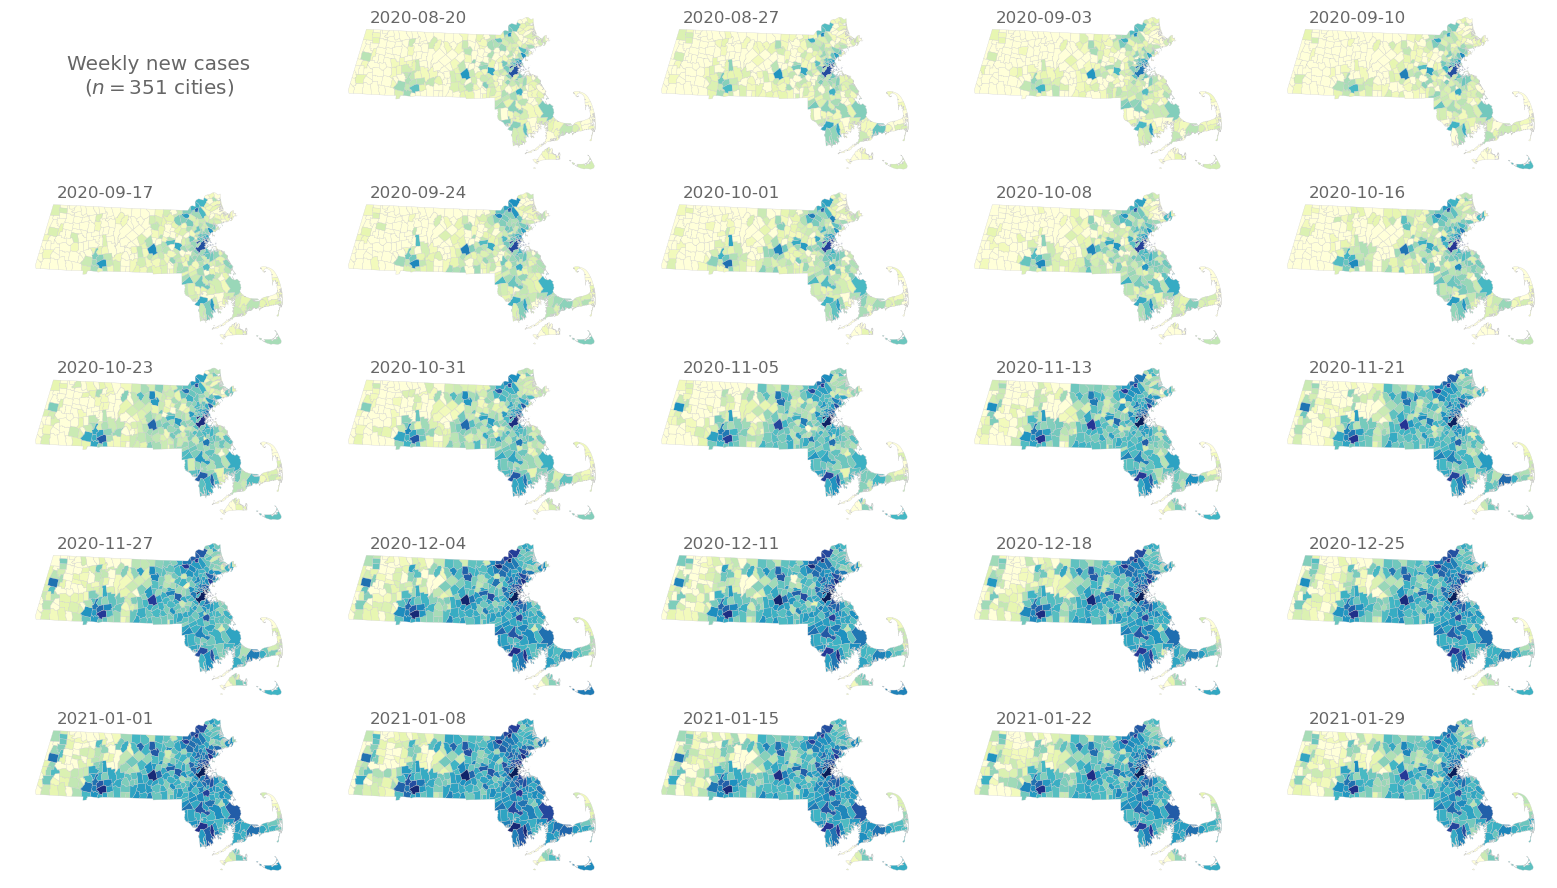

In [5]:
w = 4.0; h = 2.3
ncols = 5; nrows = 5
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100)#, sharex=True)
plt.subplots_adjust(wspace=0.05,hspace=0.05)

for di, d in enumerate(list(city_df['date'].unique())[-int(nrows*ncols):]):
    aa = ax[tups[di]]
    if di != 0:
        aa = ax[tups[di]]
        dat_shp_i = dat_shp.copy()
        dat_shp_i = dat_shp_i.merge(city_df.loc[city_df['date']==d][['city','new_cases_town']],
                                    how='left', on='city')
        dat_shp_i['new_cases_town'] = np.log(dat_shp_i['new_cases_town']+1)
        dat_shp_i.plot(ax=aa, column='new_cases_town', ec='.8', lw=0.2, cmap='YlGnBu', vmin=0, vmax=7.5)
        aa.text(0.125, 0.95, d, ha='left', va='center',
                transform=aa.transAxes, color='.4', fontsize='large')

    else:
        aa.text(0.5, 0.6, 'Weekly new cases\n($n=%i$ cities)'%city_df['city'].nunique(), color='.4',
                ha='center', va='center', transform=aa.transAxes, fontsize='x-large')

    aa.set_axis_off()


plt.savefig('../figs/pngs/ma_cities_casecounts_over_time.png',dpi=425,bbox_inches='tight')

plt.show()

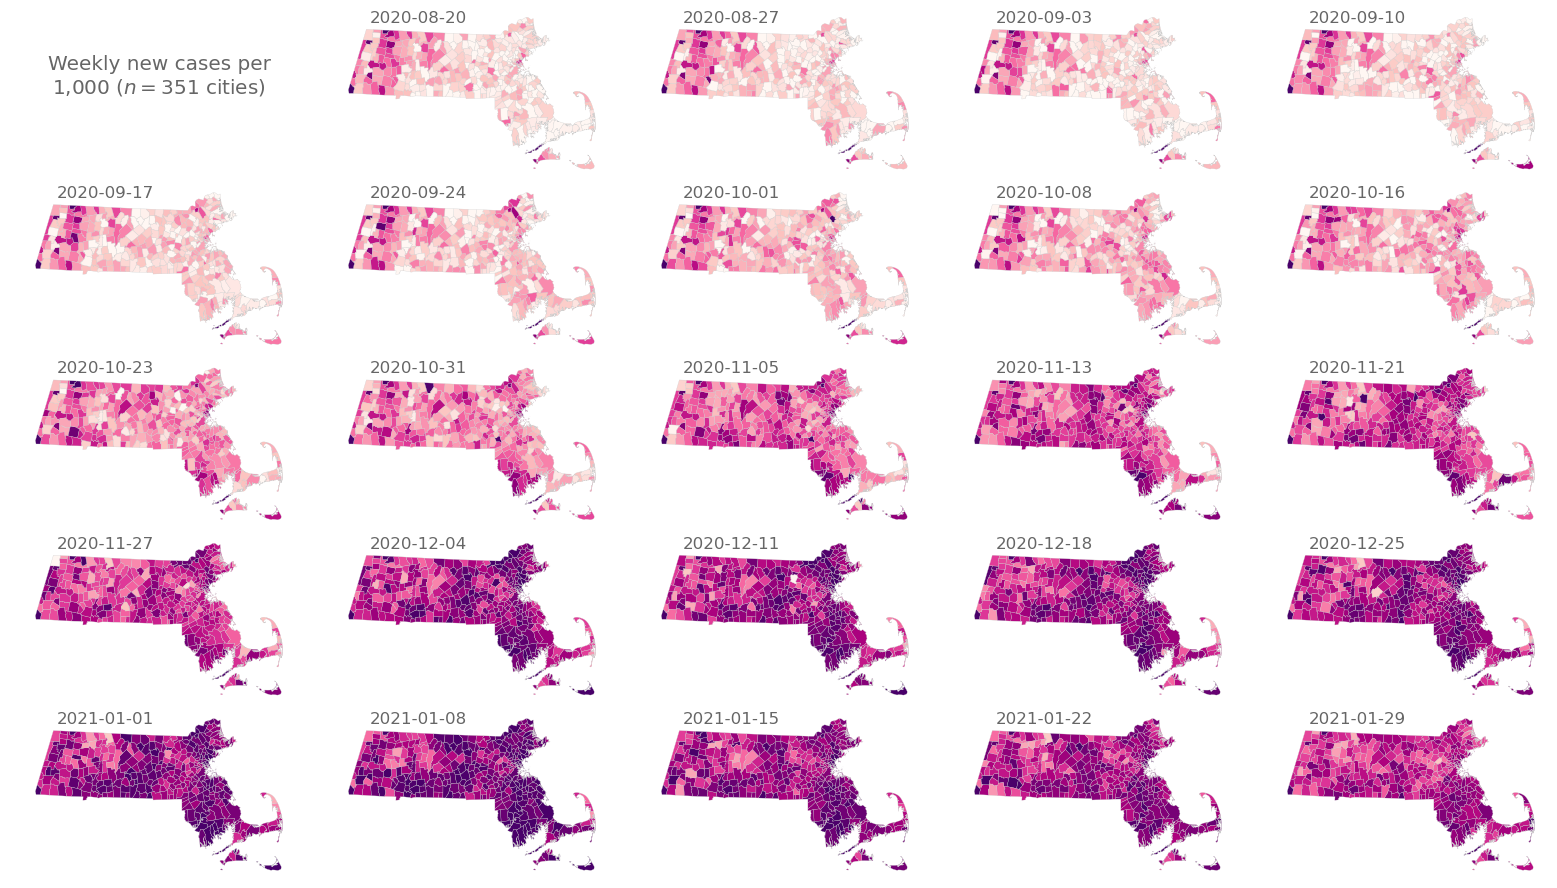

In [6]:
w = 4.0; h = 2.3
ncols = 5; nrows = 5
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100)#, sharex=True)
plt.subplots_adjust(wspace=0.05,hspace=0.05)

for di, d in enumerate(list(city_df['date'].unique())[-int(nrows*ncols):]):
    aa = ax[tups[di]]
    if di != 0:
        aa = ax[tups[di]]
        dat_shp_i = dat_shp.copy()
        dat_shp_i = dat_shp_i.merge(city_df.loc[city_df['date']==d][['city','new_cases_town','population']],
                                    how='left', on='city')
        dat_shp_i['new_cases_town'] = np.log((dat_shp_i['new_cases_town']+1) / dat_shp_i['population'] * 1000)
        dat_shp_i.plot(ax=aa, column='new_cases_town', ec='.8', lw=0.2, cmap='RdPu', vmin=-2.0, vmax=2.0)
        aa.text(0.125, 0.95, d, ha='left', va='center',
                transform=aa.transAxes, color='.4', fontsize='large')

    else:
        aa.text(0.5, 0.6, 'Weekly new cases per\n1,000 ($n=%i$ cities)'%city_df['city'].nunique(), color='.4',
                ha='center', va='center', transform=aa.transAxes, fontsize='x-large')

    aa.set_axis_off()


plt.savefig('../figs/pngs/ma_cities_casecounts_per1000_over_time.png',dpi=425,bbox_inches='tight')

plt.show()

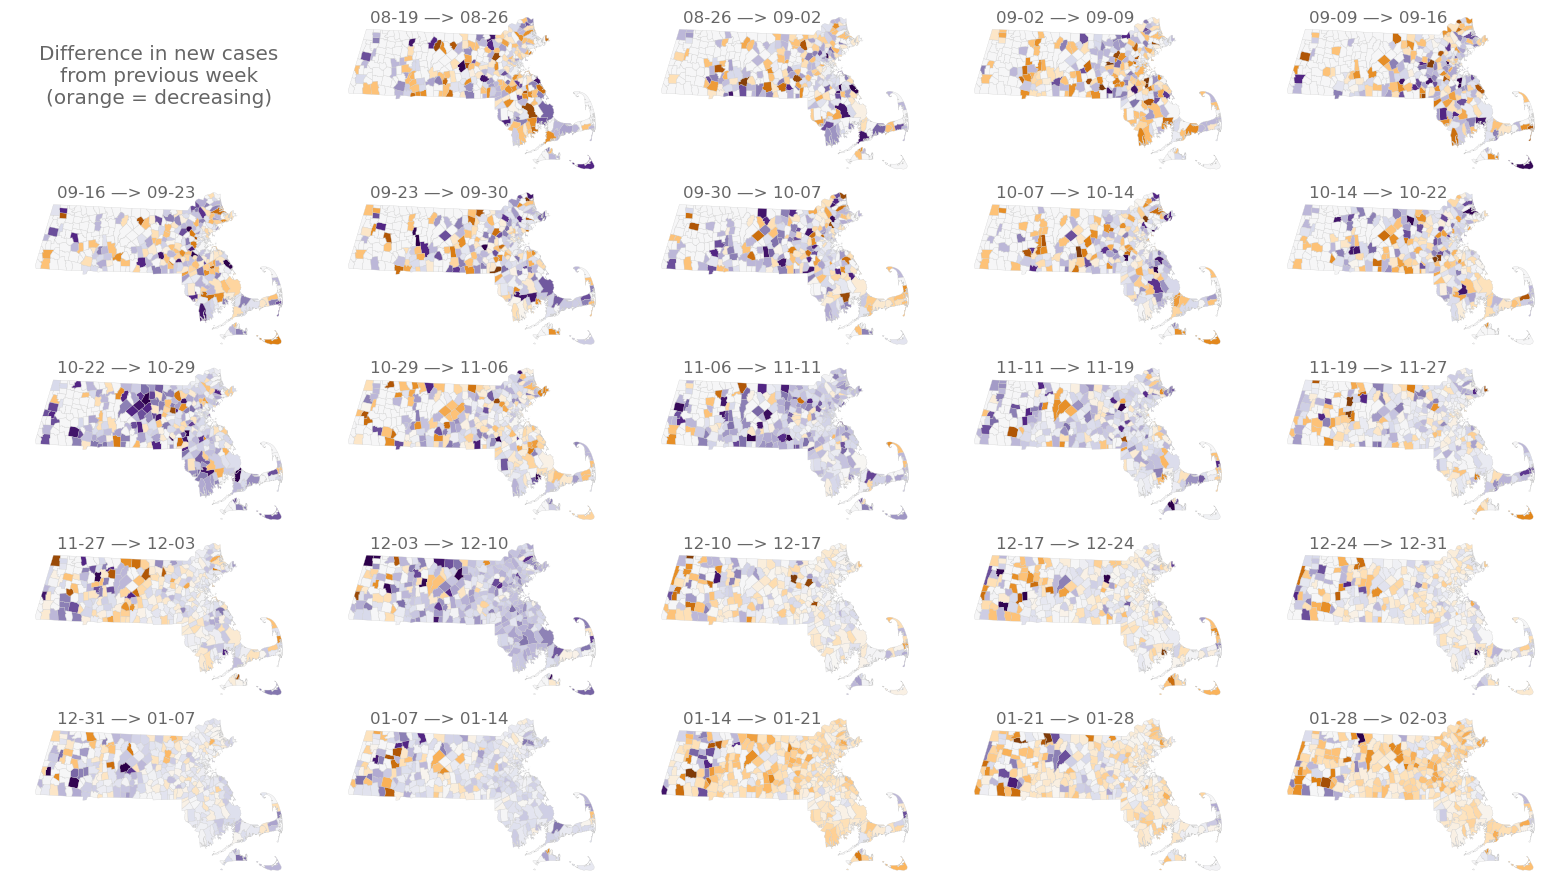

In [7]:
w = 4.0; h = 2.3
ncols = 5; nrows = 5
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100)#, sharex=True)
plt.subplots_adjust(wspace=0.05,hspace=0.05)

for di, dcurr in enumerate(list(city_df['as_of'].unique())[-int(nrows*ncols):]):
    aa = ax[tups[di]]
    if di != 0:
        dprev = list(city_df['as_of'].unique())[-int(nrows*ncols):][di-1]
        dat_shp_i = dat_shp.copy()
        dat_shp_i = dat_shp_i.merge(city_df.loc[city_df['as_of']==dcurr][['city','new_cases_town']],
                        how='left', on='city').rename(columns={'new_cases_town':'new_cases_town_curr'})
        dat_shp_i['new_cases_town_curr'] = np.log(dat_shp_i['new_cases_town_curr']+1)
        dat_shp_i = dat_shp_i.merge(city_df.loc[city_df['as_of']==dprev][['city','new_cases_town']], 
                        how='left', on='city').rename(columns={'new_cases_town':'new_cases_town_prev'})
        dat_shp_i['new_cases_town_prev'] = np.log(dat_shp_i['new_cases_town_prev']+1)

        dat_shp_i['diff'] = dat_shp_i['new_cases_town_curr'] - dat_shp_i['new_cases_town_prev']

        dat_shp_i.plot(ax=aa, column='diff', ec='.8', lw=0.2, cmap='PuOr', vmin=-2, vmax=2)
        aa.text(0.125, 0.95, dprev[5:]+" —> "+dcurr[5:], ha='left', va='center',
                transform=aa.transAxes, color='.4', fontsize='large')
    else:
        aa.text(0.5, 0.6, 'Difference in new cases\nfrom previous week\n(orange = decreasing)',
                ha='center', va='center', transform=aa.transAxes, color='.4', fontsize='x-large')
        
    aa.set_axis_off()
    

plt.savefig('../figs/pngs/ma_cities_casecounts_over_time_diff.png',dpi=425,bbox_inches='tight')

plt.show()

In [8]:
month_dict = {'01':'Jan','02':'Feb','03':'Mar','04':'Apr','05':'May','06':'Jun',
              '07':'Jul','08':'Aug','09':'Sep','10':'Oct','11':'Nov','12':'Dec'}

In [9]:
city_df['new_cases_per1000_town'] = city_df['new_cases_town'] / city_df['population'] * 1000

eligible_df = city_df.loc[(city_df['date']==city_df['date'].max())&\
                          (city_df['total_cases']>np.quantile(city_df['total_cases'],0.94))].copy()
rank_last4weeks = city_df.loc[(city_df['date'].isin(city_df['date'].unique()[-4:]))&\
                              (city_df['city'].isin(eligible_df['city'].values))].groupby('city').agg(
        {'new_cases_town':'mean'}).reset_index().sort_values('new_cases_town',ascending=False)
#         {'new_cases_per1000_town':'mean'}).reset_index().sort_values('new_cases_per1000_town',ascending=False)
rank_last4weeks.shape

(57, 2)

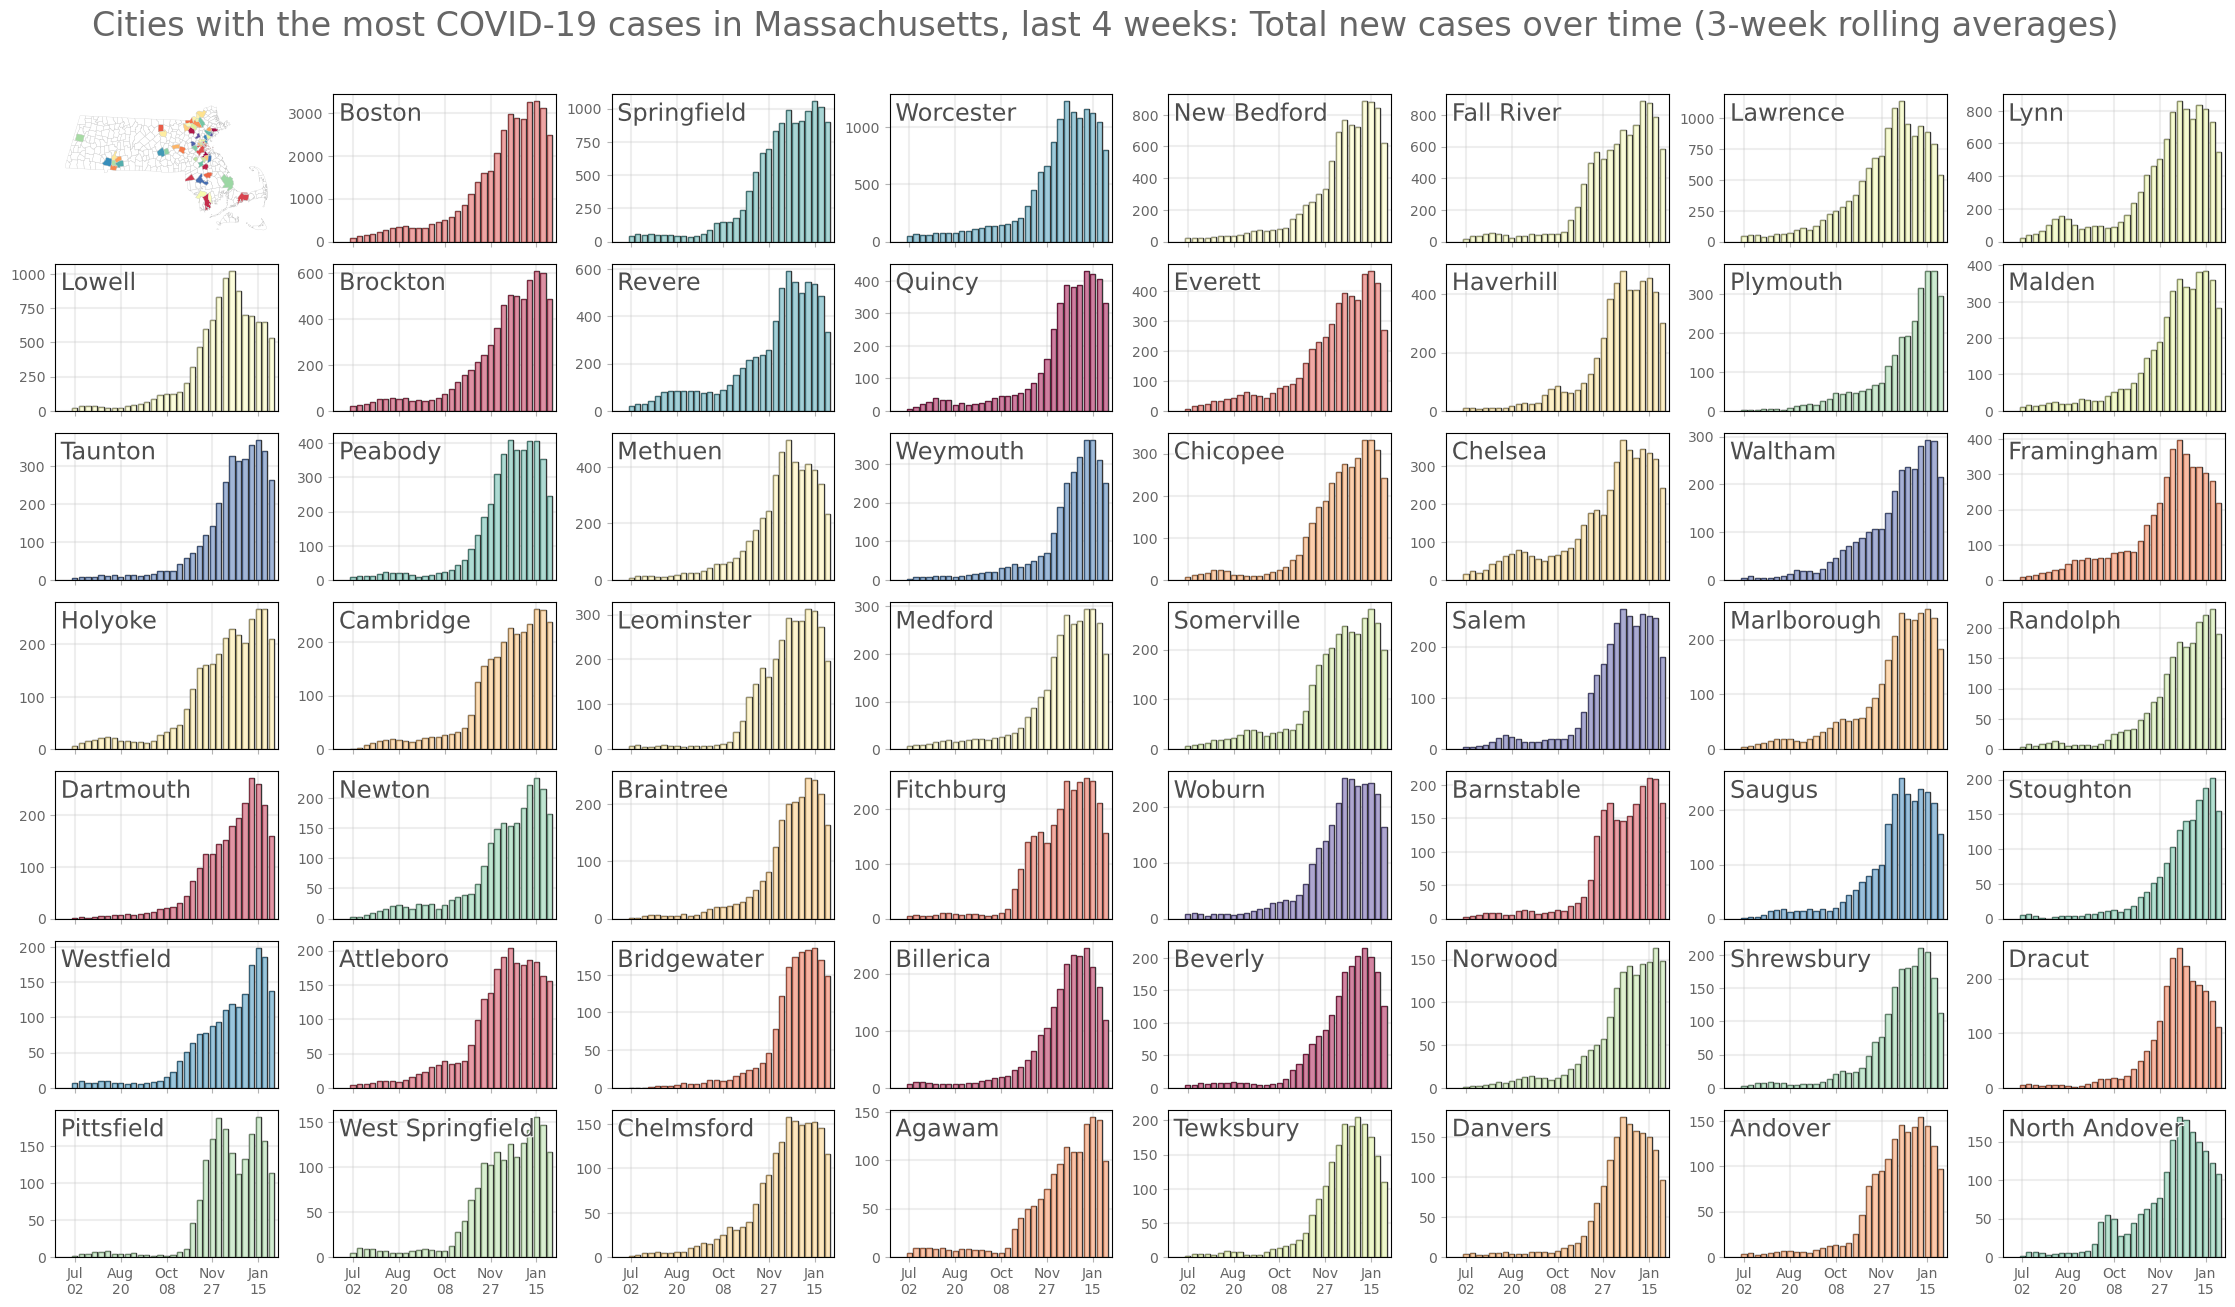

In [10]:
cmaa = plt.cm.Spectral

w = 3.5; h = 2.2
ncols = 8; nrows = 7
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100)#, sharex=True)
plt.subplots_adjust(wspace=0.25,hspace=0.15)

dat_shp.plot(ax=ax[tups[0]], ec='.8', fc='none', lw=0.2)
dat_shp_i = dat_shp.loc[dat_shp['city'].isin(rank_last4weeks['city'].values[:(nrows*ncols)-1])].copy()
dat_shp_i = dat_shp_i.reset_index().iloc[:,1:]
dat_shp_i['col'] = list(range(dat_shp_i.shape[0]))
dat_shp_i.plot(ax=ax[tups[0]], ec='.8', lw=0.2, column='col', cmap=cmaa)
ax[tups[0]].set_axis_off()

cols = cmaa(dat_shp_i['col'].values/dat_shp_i['col'].max())
cols = dict(zip(dat_shp_i['city'].values,cols))

for ci, city_i in enumerate(rank_last4weeks['city'].values[:(nrows*ncols)-1]):
    aa = ax[tups[ci+1]]
    cti = city_df.loc[city_df['city']==city_i].copy()
    xvals_i = list(range(len(cti['new_cases_per1000_town'])))
    yvals_i = cti['new_cases_per1000_town'].values
    yvals_i = cti['new_cases_town'].rolling(window=3).mean().values
    aa.bar(xvals_i, yvals_i, fc='w', ec='.2')
    aa.bar(xvals_i, yvals_i, fc=cols[city_i], ec='none',alpha=0.5)

    title_i = " ".join([i.capitalize() for i in city_i.split(' ')])

    aa.text(0.025,0.95,title_i,ha='left',va='top',transform=aa.transAxes,fontsize='xx-large',color='.3',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])
    aa.grid(linewidth=1.5,color='.75',alpha=0.25)
    aa.tick_params(labelcolor='.4',color='.7',labelsize='medium')
    aa.set_xticks([i for i in list(range(cti['date'].nunique()))[2::7]])
    if tups[ci+1][0] == nrows-1:
        aa.set_xticklabels([month_dict[i[5:7]]+"\n%s"%i[8:] for i in cti['date'].unique()[2::7]])
        
    else:
        aa.set_xticklabels(['' for i in list(range(cti['date'].nunique()))[2::7]])
        
    aa.set_xlim(list(range(city_df['date'].nunique()))[0]-1,list(range(city_df['date'].nunique()))[-1]+1)

plt.suptitle('Cities with the most COVID-19 cases in Massachusetts, last 4 weeks: '+\
             'Total new cases over time (3-week rolling averages)', y=0.935, fontsize=24,
             color='.4')

plt.savefig('../figs/pngs/ma_cities_last4weeks_ranking.png',dpi=425,bbox_inches='tight')

plt.show()

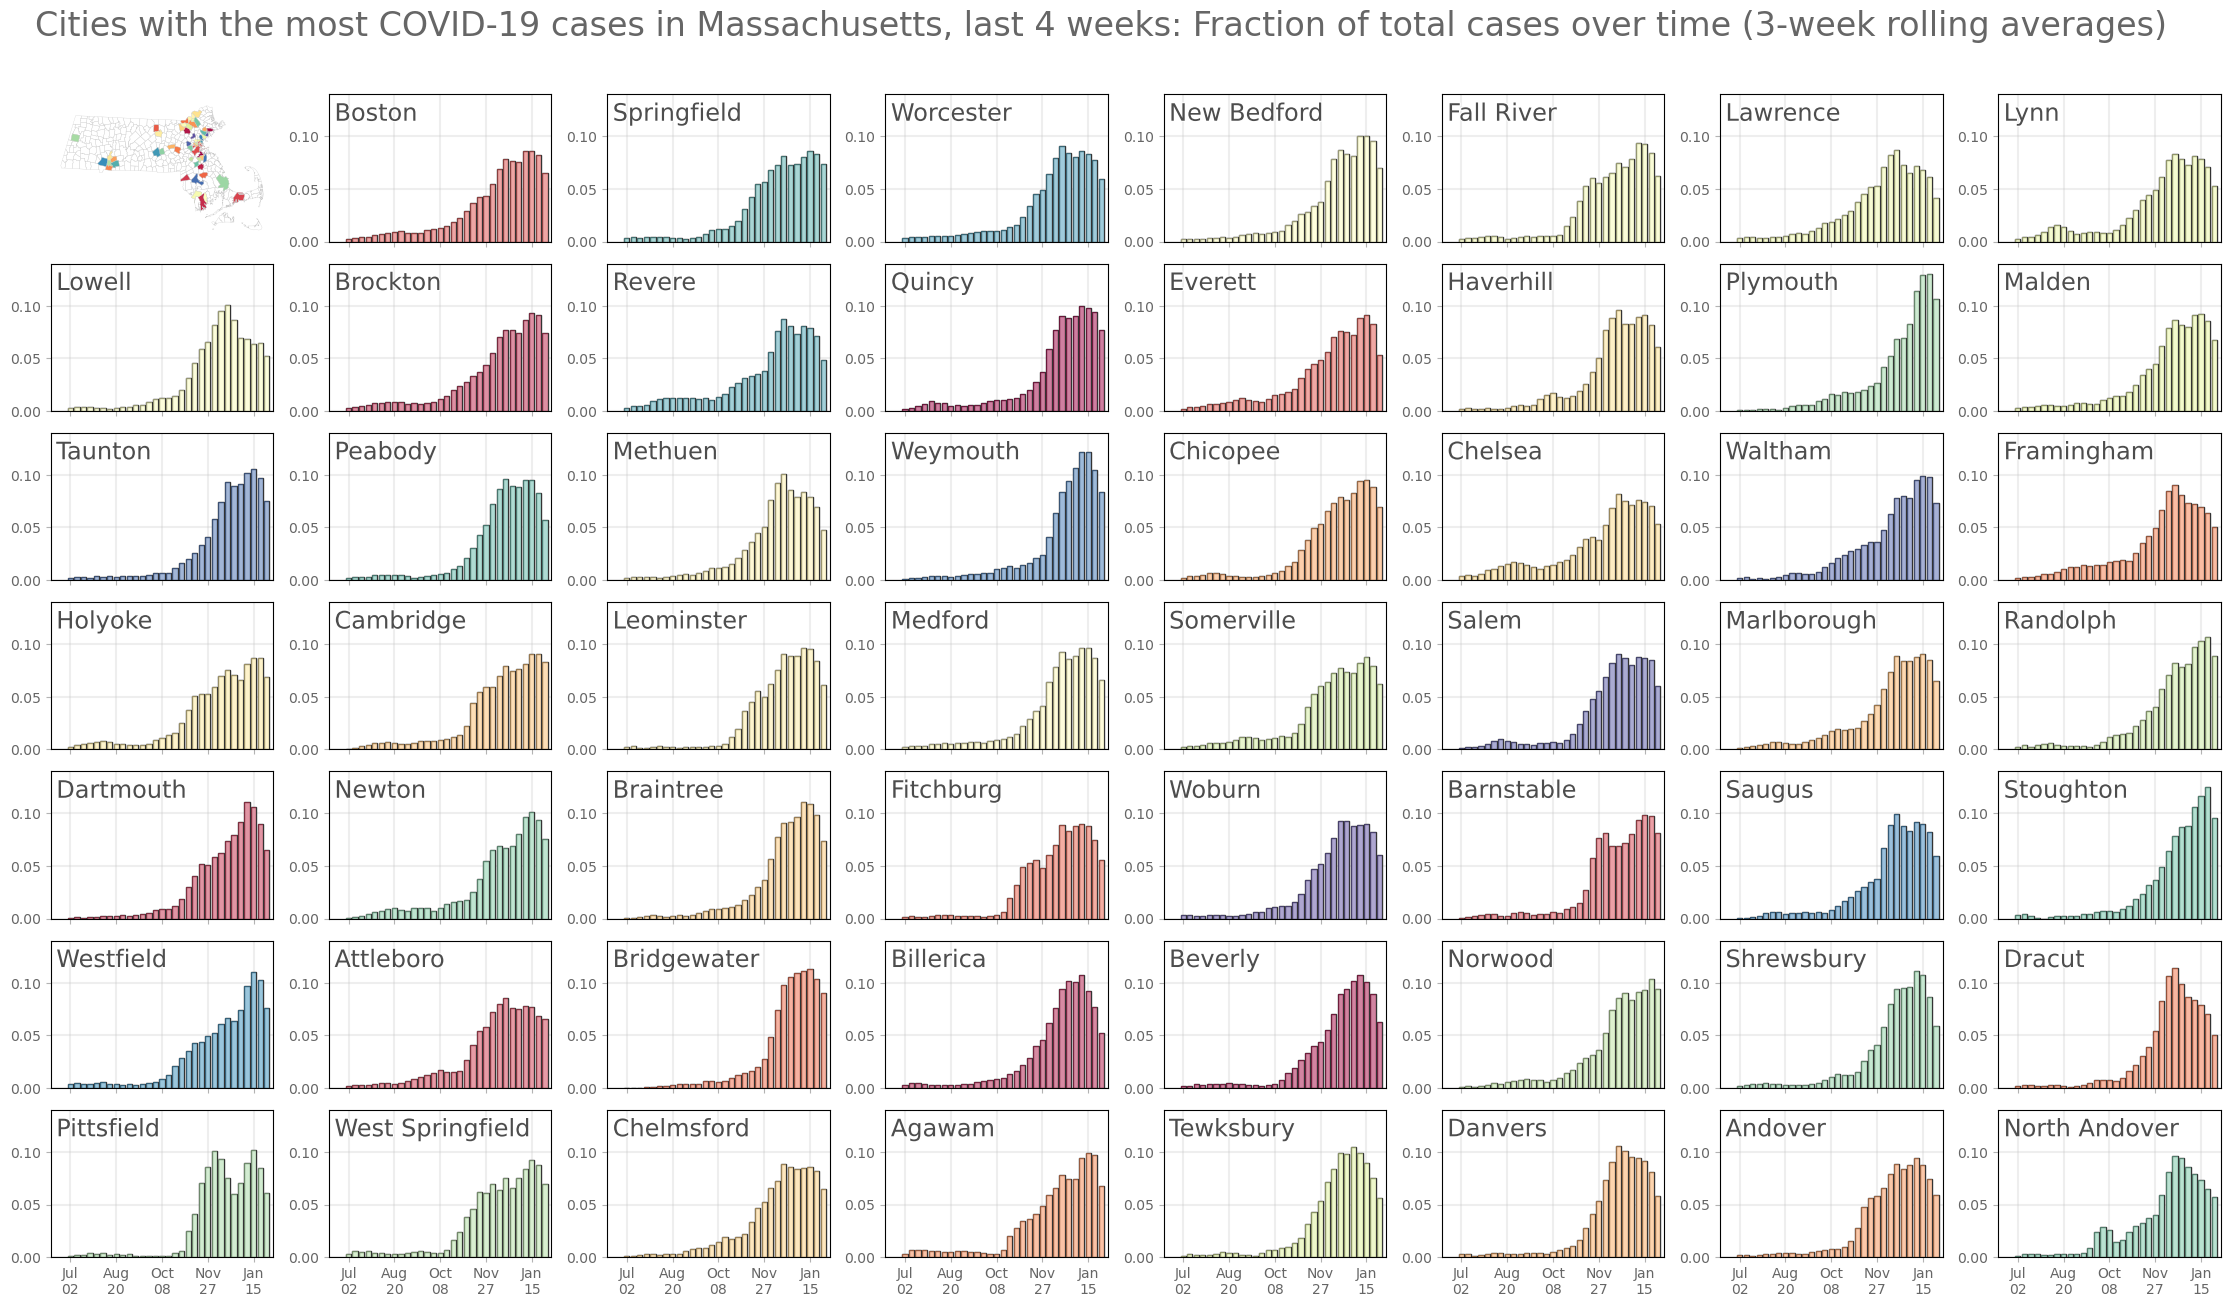

In [11]:
cmaa = plt.cm.Spectral

w = 3.5; h = 2.2
ncols = 8; nrows = 7
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100)#, sharex=True)
plt.subplots_adjust(wspace=0.25,hspace=0.15)

dat_shp.plot(ax=ax[tups[0]], ec='.8', fc='none', lw=0.2)
dat_shp_i = dat_shp.loc[dat_shp['city'].isin(rank_last4weeks['city'].values[:(nrows*ncols)-1])].copy()
dat_shp_i = dat_shp_i.reset_index().iloc[:,1:]
dat_shp_i['col'] = list(range(dat_shp_i.shape[0]))
dat_shp_i.plot(ax=ax[tups[0]], ec='.8', lw=0.2, column='col', cmap=cmaa)
ax[tups[0]].set_axis_off()

cols = cmaa(dat_shp_i['col'].values/dat_shp_i['col'].max())
cols = dict(zip(dat_shp_i['city'].values,cols))

for ci, city_i in enumerate(rank_last4weeks['city'].values[:(nrows*ncols)-1]):
    aa = ax[tups[ci+1]]
    cti = city_df.loc[city_df['city']==city_i].copy()
    xvals_i = list(range(len(cti['new_cases_per1000_town'])))
    yvals_i = cti['new_cases_per1000_town'].values
    yvals_i = cti['new_cases_town'].rolling(window=3).mean().values
    yvals_i = yvals_i / np.nansum(yvals_i)
    aa.bar(xvals_i, yvals_i, fc='w', ec='.2')
    aa.bar(xvals_i, yvals_i, fc=cols[city_i], ec='none',alpha=0.5)

    title_i = " ".join([i.capitalize() for i in city_i.split(' ')])

    aa.text(0.025,0.95,title_i,ha='left',va='top',transform=aa.transAxes,fontsize='xx-large',color='.3',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])
    aa.grid(linewidth=1.5,color='.75',alpha=0.25)
    aa.tick_params(labelcolor='.4',color='.7',labelsize='medium')
    aa.set_xticks([i for i in list(range(cti['date'].nunique()))[2::7]])
    if tups[ci+1][0] == nrows-1:
        aa.set_xticklabels([month_dict[i[5:7]]+"\n%s"%i[8:] for i in cti['date'].unique()[2::7]])
        
    else:
        aa.set_xticklabels(['' for i in list(range(cti['date'].nunique()))[2::7]])
        

    aa.set_ylim(0, 0.14)
    aa.set_xlim(list(range(city_df['date'].nunique()))[0]-1,list(range(city_df['date'].nunique()))[-1]+1)

plt.suptitle('Cities with the most COVID-19 cases in Massachusetts, last 4 weeks: '+\
             'Fraction of total cases over time (3-week rolling averages)', y=0.935, fontsize=24,
             color='.4')

plt.savefig('../figs/pngs/ma_cities_last4weeks_ranking_frac.png',dpi=425,bbox_inches='tight')

plt.show()

In [12]:
heatm = []
city_order = city_df.loc[city_df['date']==city_df['date'].max()].sort_values('total_cases').city.values[::-1]
for ci, city_i in enumerate(city_order):
    cti = city_df.loc[city_df['city']==city_i].copy()
    yvals_i = cti['new_cases_per1000_town'].rolling(window=3).mean().values
    if sum(cti['new_cases_town'])>10:
        heatm.append(yvals_i)
    else:
        heatm.append(np.zeros(cti.shape[0]))

In [13]:
import cmocean as cmo

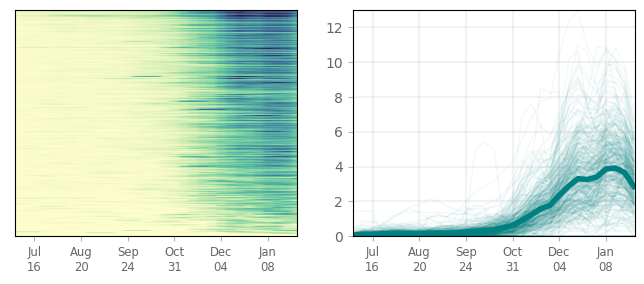

In [14]:
fig, ax = plt.subplots(1,2,figsize=(8,3),dpi=100)

ax[0].imshow(np.array(heatm),aspect='auto',vmin=0, vmax=10, cmap=cmo.cm.deep)
ax[1].plot(np.array(heatm).T, color='teal', alpha=0.05, lw=1)
ax[1].plot(np.mean(heatm,axis=0), color='teal', lw=4)
# ax.set_yticks(list(range(len(city_order)))[::10])
# ax.set_yticklabels(city_order[::10], fontsize='xx-small')
ax[0].set_yticks([])

ax[0].set_ylim(330,0)
ax[1].set_ylim(0,13)
ax[0].set_xlim(1.9,32.1)
ax[1].set_xlim(1.9,32.1)
ax[1].grid(linewidth=1.5,color='.75',alpha=0.2)
for a in fig.axes:
    a.tick_params(labelcolor='.4',color='.7',labelsize='medium')
    a.set_xticks([i for i in list(range(cti['date'].nunique()))[4::5]])
    a.set_xticklabels([month_dict[i[5:7]]+"\n%s"%i[8:] for i in cti['date'].unique()[4::5]],fontsize='small')

plt.savefig('../figs/pngs/ma_heatmap_city_cases.png',dpi=425,bbox_inches='tight')

plt.show()

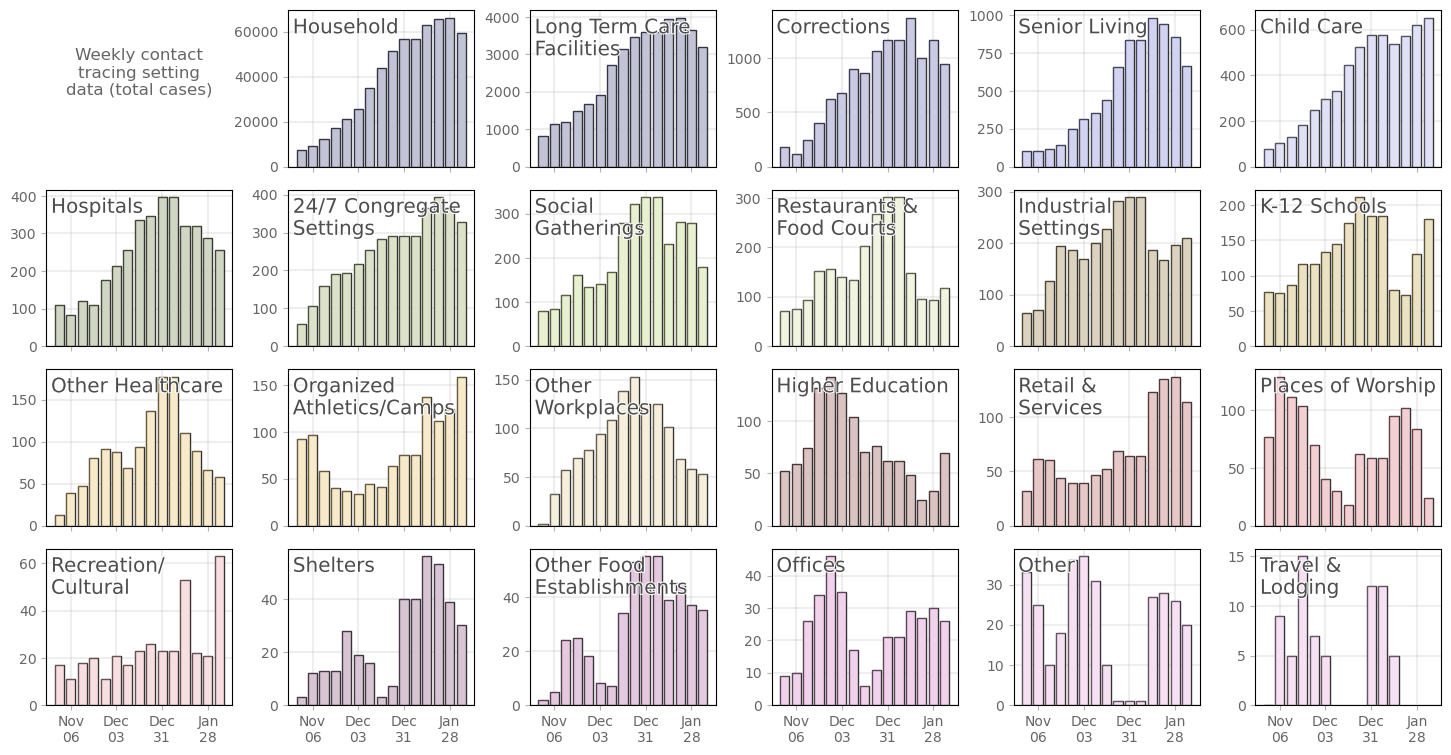

In [15]:
w = 3.0; h = 2.3
ncols = 6; nrows = 4
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True)#, sharey=True)
plt.subplots_adjust(wspace=0.3,hspace=0.15)

labs = dict(zip(contact_df['setting'].unique(),['24/7 Congregate\nSettings', 'Child Care',
       'Higher Education', 'Corrections', 'Hospitals', 'Household',
       'Industrial\nSettings', 'K-12 Schools', 'Long Term Care\nFacilities',
       'Offices', 'Organized\nAthletics/Camps', 'Other',
       'Other Food\nEstablishments', 'Other Healthcare',
       'Other\nWorkplaces', 'Places of Worship', 'Recreation/\nCultural',
       'Restaurants &\nFood Courts', 'Retail &\nServices', 'Senior Living',
       'Shelters', 'Social\nGatherings', 'Travel &\nLodging']))

ncats = contact_df['setting'].nunique()
cols = plt.cm.tab20b(np.linspace(0,1,ncats))

for di, dcurr in enumerate(contact_df.sort_values('raw_total_cases',ascending=False)['setting'].unique()):
    di += 1
    aa = ax[tups[di]]
    cti = contact_df.loc[contact_df['setting']==dcurr].copy()
    aa.bar(list(range(len(cti['raw_total_cases']))),cti['raw_total_cases'].values,fc='w',ec='.2')
    aa.bar(list(range(len(cti['raw_total_cases']))),cti['raw_total_cases'].values,fc=cols[di-1],
           ec='none',alpha=0.3)
    
    aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',transform=aa.transAxes,fontsize='x-large',color='.3',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])
    aa.grid(linewidth=1.5,color='.75',alpha=0.25)
    aa.tick_params(labelcolor='.4',color='.7',labelsize='medium')
    aa.set_xticks([i for i in list(range(contact_df['data_date'].nunique()))[1::4]])
    aa.set_xticklabels([month_dict[i[5:7]]+"\n%s"%i[8:] for i in contact_df['data_date'].unique()[1::4]])


aa = ax[tups[0]]
aa.text(0.5, 0.6, 'Weekly contact\ntracing setting\ndata (total cases)', ha='center', va='center',
            transform=aa.transAxes, color='.4', fontsize='large')

aa.set_axis_off()


plt.savefig('../figs/pngs/ma_outbreak_settings_cases.png',dpi=425,bbox_inches='tight')

plt.show()

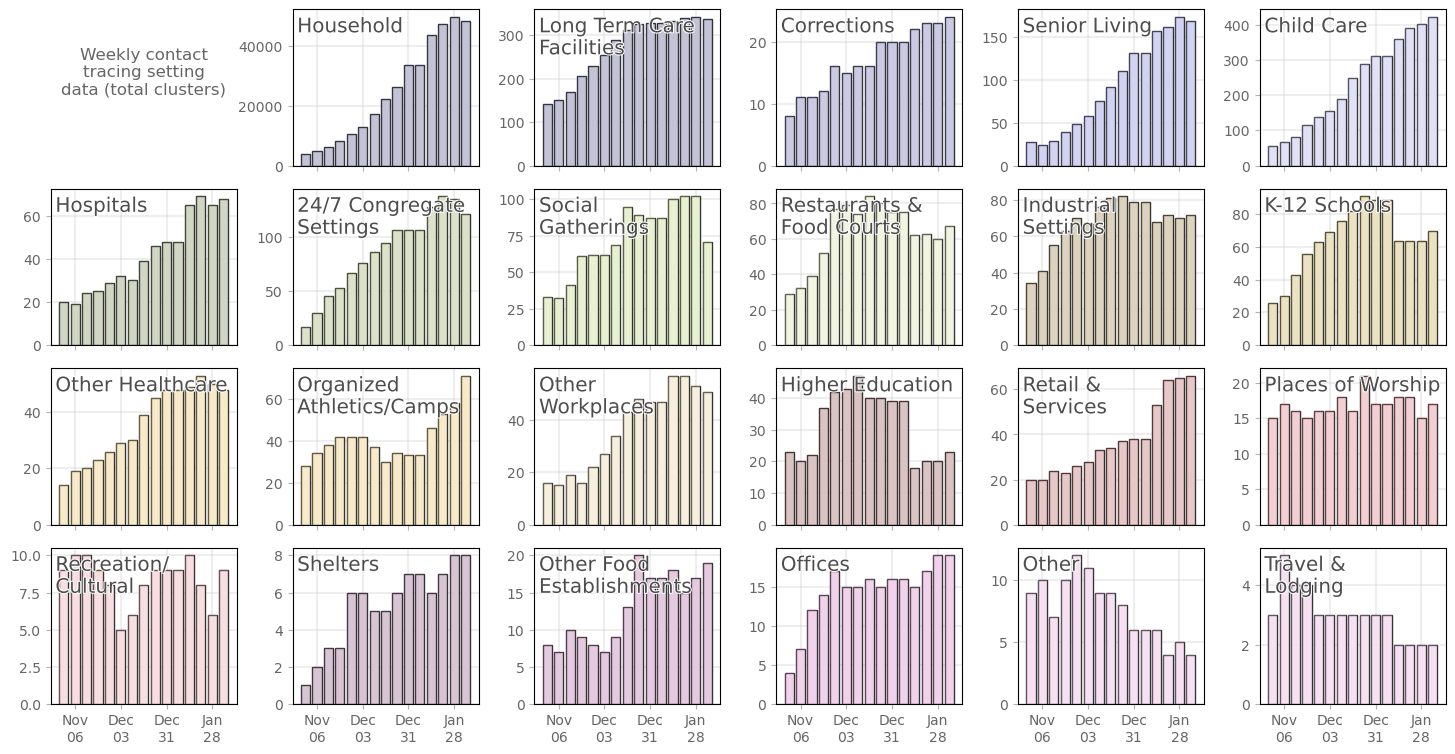

In [16]:
w = 3.0; h = 2.3
ncols = 6; nrows = 4
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True)#, sharey=True)
plt.subplots_adjust(wspace=0.3,hspace=0.15)

labs = dict(zip(contact_df['setting'].unique(),['24/7 Congregate\nSettings', 'Child Care',
       'Higher Education', 'Corrections', 'Hospitals', 'Household',
       'Industrial\nSettings', 'K-12 Schools', 'Long Term Care\nFacilities',
       'Offices', 'Organized\nAthletics/Camps', 'Other',
       'Other Food\nEstablishments', 'Other Healthcare',
       'Other\nWorkplaces', 'Places of Worship', 'Recreation/\nCultural',
       'Restaurants &\nFood Courts', 'Retail &\nServices', 'Senior Living',
       'Shelters', 'Social\nGatherings', 'Travel &\nLodging']))

ncats = contact_df['setting'].nunique()
cols = plt.cm.tab20b(np.linspace(0,1,ncats))

for di, dcurr in enumerate(contact_df.sort_values('raw_total_cases',ascending=False)['setting'].unique()):
    di += 1
    aa = ax[tups[di]]
    cti = contact_df.loc[contact_df['setting']==dcurr].copy()
    aa.bar(list(range(len(cti['raw_total_clusters']))),cti['raw_total_clusters'].values,fc='w',ec='.2')
    aa.bar(list(range(len(cti['raw_total_clusters']))),cti['raw_total_clusters'].values,fc=cols[di-1],
           ec='none',alpha=0.3)
    
    aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',transform=aa.transAxes,fontsize='x-large',color='.3',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])
    aa.grid(linewidth=1.5,color='.75',alpha=0.25)
    aa.tick_params(labelcolor='.4',color='.7',labelsize='medium')
    aa.set_xticks([i for i in list(range(contact_df['data_date'].nunique()))[1::4]])
    aa.set_xticklabels([month_dict[i[5:7]]+"\n%s"%i[8:] for i in contact_df['data_date'].unique()[1::4]])

aa = ax[tups[0]]
aa.text(0.5, 0.6, 'Weekly contact\ntracing setting\ndata (total clusters)', ha='center', va='center',
            transform=aa.transAxes, color='.4', fontsize='large')

aa.set_axis_off()


plt.savefig('../figs/pngs/ma_outbreak_settings_clusters.png',dpi=425,bbox_inches='tight')

plt.show()

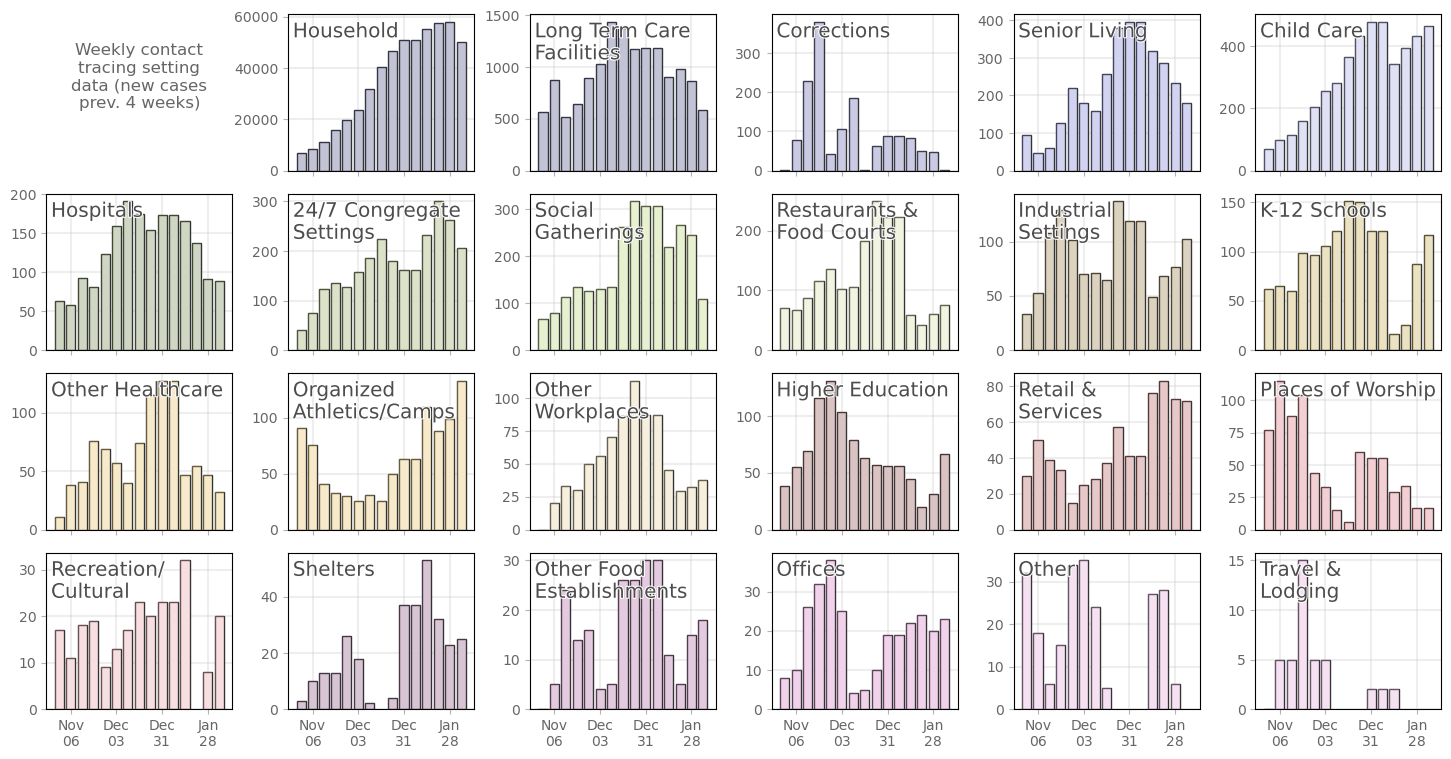

In [17]:
w = 3.0; h = 2.3
ncols = 6; nrows = 4
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True)#, sharey=True)
plt.subplots_adjust(wspace=0.3,hspace=0.15)

labs = dict(zip(contact_df['setting'].unique(),['24/7 Congregate\nSettings', 'Child Care',
       'Higher Education', 'Corrections', 'Hospitals', 'Household',
       'Industrial\nSettings', 'K-12 Schools', 'Long Term Care\nFacilities',
       'Offices', 'Organized\nAthletics/Camps', 'Other',
       'Other Food\nEstablishments', 'Other Healthcare',
       'Other\nWorkplaces', 'Places of Worship', 'Recreation/\nCultural',
       'Restaurants &\nFood Courts', 'Retail &\nServices', 'Senior Living',
       'Shelters', 'Social\nGatherings', 'Travel &\nLodging']))

ncats = contact_df['setting'].nunique()
cols = plt.cm.tab20b(np.linspace(0,1,ncats))

for di, dcurr in enumerate(contact_df.sort_values('raw_total_cases',ascending=False)['setting'].unique()):
    di += 1
    aa = ax[tups[di]]
    cti = contact_df.loc[contact_df['setting']==dcurr].copy()
    aa.bar(list(range(len(cti['raw_new_cases']))),cti['raw_new_cases'].values,fc='w',ec='.2')
    aa.bar(list(range(len(cti['raw_new_cases']))),cti['raw_new_cases'].values,fc=cols[di-1],
           ec='none',alpha=0.3)
    
    aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',transform=aa.transAxes,fontsize='x-large',color='.3',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])
    aa.grid(linewidth=1.5,color='.75',alpha=0.25)
    aa.tick_params(labelcolor='.4',color='.7',labelsize='medium')
    aa.set_xticks([i for i in list(range(contact_df['data_date'].nunique()))[1::4]])
    aa.set_xticklabels([month_dict[i[5:7]]+"\n%s"%i[8:] for i in contact_df['data_date'].unique()[1::4]])


aa = ax[tups[0]]
aa.text(0.5, 0.6, 'Weekly contact\ntracing setting\ndata (new cases\nprev. 4 weeks)',
        ha='center', va='center', transform=aa.transAxes, color='.4', fontsize='large')

aa.set_axis_off()


plt.savefig('../figs/pngs/ma_outbreak_settings_newcases.png',dpi=425,bbox_inches='tight')

plt.show()

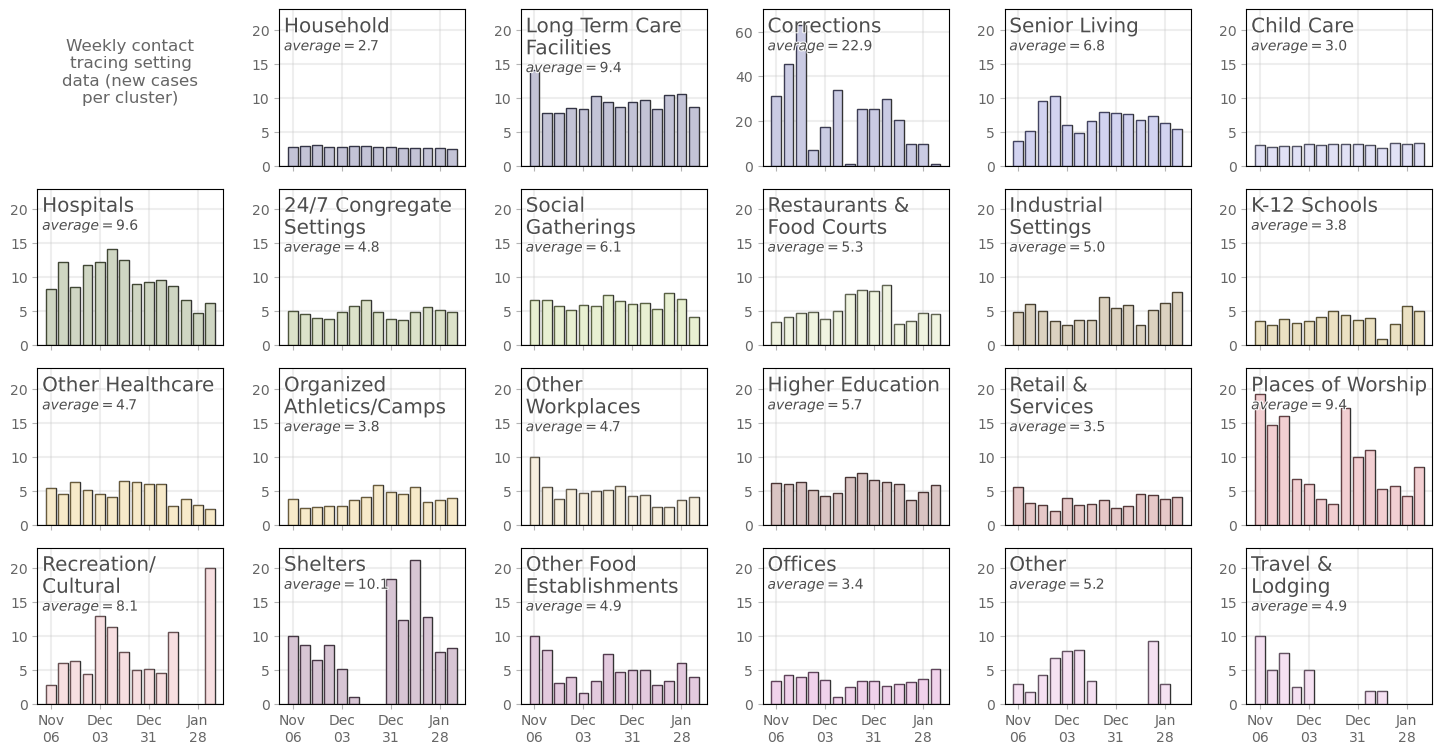

In [18]:
w = 3.0; h = 2.3
ncols = 6; nrows = 4
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True)#, sharey=True)
plt.subplots_adjust(wspace=0.3,hspace=0.15)

labs = dict(zip(contact_df['setting'].unique(),['24/7 Congregate\nSettings', 'Child Care',
       'Higher Education', 'Corrections', 'Hospitals', 'Household',
       'Industrial\nSettings', 'K-12 Schools', 'Long Term Care\nFacilities',
       'Offices', 'Organized\nAthletics/Camps', 'Other',
       'Other Food\nEstablishments', 'Other Healthcare',
       'Other\nWorkplaces', 'Places of Worship', 'Recreation/\nCultural',
       'Restaurants &\nFood Courts', 'Retail &\nServices', 'Senior Living',
       'Shelters', 'Social\nGatherings', 'Travel &\nLodging']))

ncats = contact_df['setting'].nunique()
cols = plt.cm.tab20b(np.linspace(0,1,ncats))

for di, dcurr in enumerate(contact_df.sort_values('raw_total_cases',ascending=False)['setting'].unique()):
    di += 1
    aa = ax[tups[di]]
    cti = contact_df.loc[contact_df['setting']==dcurr].copy()
    cti['raw_new_cases_per'] = cti['raw_new_cases'] / cti['raw_new_clusters'].rolling(window=2).mean()
    aa.bar(list(range(len(cti['raw_new_cases']))),cti['raw_new_cases_per'].values,fc='w',ec='.2')
    aa.bar(list(range(len(cti['raw_new_cases']))),cti['raw_new_cases_per'].values,fc=cols[di-1],
           ec='none',alpha=0.3)

    aa.text(0.025,0.95,labs[dcurr],
            ha='left', va='top',transform=aa.transAxes, fontsize='x-large',color='.3',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])
    ym = 0.815
    if "\n" in labs[dcurr]:
        ym = 0.675
    aa.text(0.025,ym,'$average=%.1f$'%(cti['raw_new_cases_per'].dropna().mean()),
            ha='left', va='top',transform=aa.transAxes, fontsize='medium',color='.3',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])

    aa.grid(linewidth=1.5,color='.75',alpha=0.25)
    aa.tick_params(labelcolor='.4',color='.7',labelsize='medium')
    aa.set_xticks([i for i in list(range(contact_df['data_date'].nunique()))[1::4]])
    if labs[dcurr] == 'Corrections':
        aa.set_ylim(0, 70)
    else:
        aa.set_ylim(0, 23)
    aa.set_xticklabels([month_dict[i[5:7]]+"\n%s"%i[8:] for i in contact_df['data_date'].unique()[1::4]])


aa = ax[tups[0]]
aa.text(0.5, 0.6, 'Weekly contact\ntracing setting\ndata (new cases\nper cluster)',
        ha='center', va='center', transform=aa.transAxes, color='.4', fontsize='large')

aa.set_axis_off()

plt.savefig('../figs/pngs/ma_outbreak_settings_newcases_per.png',dpi=425,bbox_inches='tight')

plt.show()